# Credits

This is heavily influenced from https://github.com/pytorch/tutorials

# CIFAR-10

In thins notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’.
The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

![cifar10](../static_files/cifar10.png)


In order to train a classifier the following steps needs to be performed:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

We will help you along the way.
We indicate the places you need to modify the code with `# Your code here!`.
It is however a good idea to read the entire assignment before you begin coding!

## 1. Loading and normalizing CIFAR10

Using ``torchvision``, it’s extremely easy to load CIFAR10.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1]

**NB** Modify the code below to only use a small part of the dataset if your computer is very slow.

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5),
                          (0.5, 0.5, 0.5))]
)

# Load dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
print()

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

used_categories = range(len(classes))

## USE CODE BELOW IF YOUR COMPUTER IS TOO SLOW
reduce_dataset = False
if reduce_dataset:
    used_categories = (3, 5) # cats and dogs

    classes = [classes[i] for i in used_categories]
    new_train_data = []
    new_train_labels = []

    new_test_data = []
    new_test_labels = []
    for i, t in enumerate(used_categories):
        new_train_data.append(trainset.train_data[np.where(np.array(trainset.train_labels) == t)])
        new_train_labels += [i for _ in range(new_train_data[-1].shape[0])]

        new_test_data.append(testset.test_data[np.where(np.array(testset.test_labels) == t)])
        new_test_labels += [i for _ in range(new_test_data[-1].shape[0])]

    new_train_data = np.concatenate(new_train_data, 0)
    trainset.train_data = new_train_data
    trainset.train_labels = new_train_labels

    new_test_data = np.concatenate(new_test_data, 0)
    testset.test_data = new_test_data
    testset.test_labels = new_test_labels

    
trainloader = torch.utils.data.DataLoader(trainset, batch_size=200,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=200,
                                         shuffle=True, num_workers=2)
train_data_iter = iter(trainloader)
test_data_iter = iter(testloader)
print('used classes:', classes)

Files already downloaded and verified
Files already downloaded and verified

used classes: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [4]:
print("Training data")
print(trainset.train_data.shape)
print(len(trainset.train_labels))
print()

print("Test data")
print(testset.test_data.shape)
print(len(testset.test_labels))
print()

Training data
(50000, 32, 32, 3)
50000

Test data
(10000, 32, 32, 3)
10000



Let us show some of the training images, for fun.



 deer truck  deer   dog   dog   car   car   dog horse   cat   car truck   dog plane  frog   cat


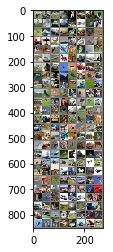

In [5]:
# Run this cell multiple time to see more samples

def imshow(img):
    """ show an image """
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
images, labels = train_data_iter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(16)))

## 2. Define a Convolutional Neural Network

**Assignment 1:** Define a convolutional neural network. 
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully come back and improve the architecture

In [6]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Conv2d, MaxPool2d, BatchNorm1d, Dropout, Linear

def compute_conv_dim(dim_size, kernel_size, padding, stride):
    return int((dim_size - kernel_size + 2 * padding) / stride + 1)


class Net(nn.Module):
    def __init__(self, num_classes, hidden_1, num_filters_1, kernel_size_1, stride=1, padding=0):
        super(Net, self).__init__()
        self.num_classes = num_classes
        
        self.conv_1 = Conv2d(in_channels=3,
                            out_channels=num_filters_1,
                            kernel_size=kernel_size_1,
                            stride=stride,
                            padding=padding)
        
        self.max_pool1 = MaxPool2d(kernel_size=2)
        self.conv1_height = int(compute_conv_dim(32, kernel_size_1, padding, stride)/2)
        self.conv1_width = int(compute_conv_dim(32, kernel_size_1, padding, stride)/2)
        
        self.l_1_features = num_filters_1*self.conv1_height*self.conv1_width 

        self.l_1 = Linear(in_features=self.l_1_features
                          ,out_features=hidden_1
                         ,bias=True)
        self.l_2 = Linear(in_features=hidden_1
                         , out_features=num_classes
                         , bias=False)


    def forward(self, x):

        x = F.relu(self.max_pool1(self.conv_1(x)))
        x = x.view(-1, self.l_1_features)
        #x = self.dropout(x)
        x = F.relu(self.l_1(x))
        x = F.softmax(self.l_2(x),dim=1)

        return x
    

net = Net(len(used_categories), hidden_1=512, num_filters_1=16, kernel_size_1=5).cuda()


## 3. Define a Loss function and optimizer

**Assignment 2:** Implement the criterion and optimizer. 
We suggest Classification Cross-Entropy loss and SGD with momentum.
You might need to experiment a bit with the learning rate.

In [7]:
import torch.optim as optim


net = Net(len(used_categories), hidden_1=512, num_filters_1=16, kernel_size_1=5).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

## 4. Train the network

**Assignment 3:** Finish the training loop below. 
Start by using a small number of epochs (e.g. 3).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

In [8]:
from sklearn.metrics import accuracy_score

def test_acc(net):
    correct = 0
    total = 0

    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = net(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    print('Accuracy of the network on the {} test images: {:4.2f} %'.format(
        testset.test_data.shape[0], 100 * correct / total))


def train(net, optimizer, num_epoch=50):
    train_acc =[]

    for epoch in range(num_epoch):  # loop over the dataset multiple times

        running_loss = 0.0
        running_train_acc = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the input
            inputs, labels = data
            # wrap them in Variable
            inputs, labels = Variable(inputs).cuda(), Variable(labels).cuda()

            net.train()

            output = net(inputs)
            predictions = torch.max(output, 1)[1]
            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            net.eval()
            # print statistics
            running_loss += loss
            running_train_acc += accuracy_score(predictions.detach(), labels.detach())
            #if i % 10 == 9:    # print every 1000 mini-batches
        print('[%d, %5d] loss: %.3f  training acc = %0.3f' %
                      (epoch + 1, i + 1, running_loss / (i+1), running_train_acc/(i+1) ))
        train_acc.append(running_train_acc/(i+1))
        running_loss = 0.0
        running_train_acc = 0.0

    plt.plot(np.arange(len(train_acc)),train_acc)
    print('Finished Training')
    


In [ ]:
train(net, optimizer)
test_acc(net)

## 5. Test the network on the test data

Now we need to check if the network has learnt anything at all.
We will check this by predicting the class label that the neural network outputs, and checking it against the ground truth.
If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

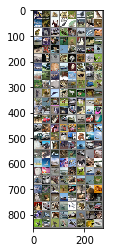

GroundTruth:   truck  frog   cat   cat  deer  bird plane  bird plane  frog horse plane  frog horse   cat  frog
Predicted:     truck  frog  frog  frog  deer  bird plane  bird plane  frog horse plane  frog horse   cat  frog


In [31]:
images, labels = test_data_iter.next()
images, labels = images.cuda(), labels.cuda()
# print images
imshow(torchvision.utils.make_grid(images.cpu()))
plt.show()

print('GroundTruth:  ', ' '.join('%5s' % classes[labels[j]] for j in range(16)))
outputs = net(images)
_, predicted = torch.max(outputs.data, 1)
print('Predicted:    ', ' '.join('%5s' % classes[predicted[j]] for j in range(16)))

Let us look at how the network performs on the whole dataset.

In [49]:
def test_acc(net):
    correct = 0
    total = 0

    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = net(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    print('Accuracy of the network on the {} test images: {:4.2f} %'.format(
        testset.test_data.shape[0], 100 * correct / total))

Accuracy of the network on the 10000 test images: 61.00 %


Hopefully the network is better than chance, which is $\frac{1}{\text{number of classes}}$ accuracy (randomly picking
a class).


We can also examine which class the network found the most difficult (makes more sense if you have many clases):

In [51]:
class_total = list(0. for i in range(len(classes)))
class_correct = list(0. for i in range(len(classes)))

for data in testloader:
    images, labels = data
    images, labels = images.cuda(), labels.cuda()
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    
    for i in range(len(c)):
        label = labels[i]
        class_correct[label] += int(c[i])
        class_total[label] += 1

for i in range(len(classes)):
    print('Accuracy of {:5s} : {:5.2f} %'.format(
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 67.40 %
Accuracy of car   : 70.00 %
Accuracy of bird  : 49.00 %
Accuracy of cat   : 44.00 %
Accuracy of deer  : 53.50 %
Accuracy of dog   : 50.50 %
Accuracy of frog  : 70.70 %
Accuracy of horse : 69.40 %
Accuracy of ship  : 74.60 %
Accuracy of truck : 68.30 %


**Assignment 4:** 
1. Go back and improve performance of the network. 
 * If you are using all 10 classes you should get a test accuracy above 55%, but see how much further you can get it!
 * If you are using only 2 classes (e.g. cat and dog) you should get a test accuracy above 60%, but see how much further you can get it!

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?

3. Write down key lessons/insights you got (if any) during this exercise.

**Answer:**

Initial model: 1 convolutional layer (16 filters, 5 kernel_size) and one hidden layer (512 neurons)
Training acc ~40%, test acc ~37%

1. First step was to increase the batch size significantly, in order to better take advantage of the GPU, and secondly i increased the number of epochs since the model obviusly hadn't converged after 3 epochs
Training acc ~88%, test acc ~ 61%

2. I now started seeing some overfitting (88% vs 61% acc), so added some regularization in the form of L2 regularization, but this didn't improve the results that much.One may notice, that the learning doesn't seem to have converged yet, so one improvement, could be to just run the training for more epochs. Alternatively, we should most likely make a more complex model (state of the art models on this dataset, has alot of layers)

[1,   250] loss: 2.261  training acc = 0.203
[2,   250] loss: 2.146  training acc = 0.317
[3,   250] loss: 2.102  training acc = 0.358
[4,   250] loss: 2.078  training acc = 0.385
[5,   250] loss: 2.054  training acc = 0.413
[6,   250] loss: 2.035  training acc = 0.432
[7,   250] loss: 2.016  training acc = 0.452
[8,   250] loss: 1.999  training acc = 0.470
[9,   250] loss: 1.984  training acc = 0.487
[10,   250] loss: 1.968  training acc = 0.504
[11,   250] loss: 1.954  training acc = 0.518
[12,   250] loss: 1.943  training acc = 0.530
[13,   250] loss: 1.934  training acc = 0.542
[14,   250] loss: 1.925  training acc = 0.549
[15,   250] loss: 1.917  training acc = 0.559
[16,   250] loss: 1.911  training acc = 0.565
[17,   250] loss: 1.905  training acc = 0.574
[18,   250] loss: 1.900  training acc = 0.578
[19,   250] loss: 1.896  training acc = 0.583
[20,   250] loss: 1.890  training acc = 0.590
[21,   250] loss: 1.885  training acc = 0.596
[22,   250] loss: 1.882  training acc = 0.5

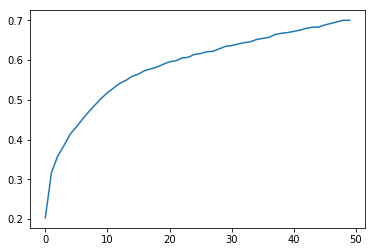

In [12]:
net = Net(len(used_categories), hidden_1=512, num_filters_1=16, kernel_size_1=5).cuda()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=3e-3)
train(net, optimizer)
test_acc(net)

# Training on GPU

**Optional Assignment:**
If you have a GPU we suggest that you try and rewrite the code above to run on the GPU
___

Just like how you transfer a Tensor on to the GPU, you transfer the neural net onto the GPU.
This will recursively go over all modules and convert their parameters and buffers to CUDA tensors:

```
    net.cuda()
```

Remember that you will have to send the inputs and targets at every step to the GPU too:

```
    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
```

Why dont I notice MASSIVE speedup compared to CPU? 
Because your network is realllly small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images




# Michael Nielsen book exercise of own choice

**Assignment 5:** Pick an exercise of own choice from [Michael Nielsens book](http://neuralnetworksanddeeplearning.com/)

**Answer:**
### Problem: The idea of convolutional layers is to behave in an invariant way across images. It may seem surprising, then, that our network can learn more when all we've done is translate the input data. Can you explain why this is actually quite reasonable?

By manipulating the data slightly, what we basically are doing, is implicitly adding some regularization. This is due to the fact that the more data you have, the more complex your model has to be in order to overfit. In this case, it could correspond to adding a slight amount of noise to the image, which should force the model to learn a more robust mapping. One might argue, that since we are using pooling, the model should not be effected by small translations. But since our max pool kernel is 2x2, there is a 50% change that the pixel will move to the neighbouring kernel. The change is small, but again, even a small amount of added noise should reduce overfitting 


